In [1]:
'''
    多因子选股：聚类+择时
    给出需要执行策略的时间区间
    
    based on Jupyter Notebook  
    version：python3.6
    liuhuanshuo：huanshuo0801@Gmail.com
    Apr,11,2018
'''

'\n    一个量化投资轮动策略\n    给出需要执行策略的时间区间以及收益率排名个数\n    每个星期最后一个交易日平仓，算出下一个星期市盈率最低的n只股票，在下个星期第一个开盘时以开盘价买入。\n    \n    based on Jupyter Notebook  \n    version：python3.6\n    liuhuanshuo：huanshuo0801@Gmail.com\n    Apr,11,2018\n'

In [32]:
from sklearn.cluster import KMeans
import pandas as pd
import time
import os
from pandas.core.frame import DataFrame
import tushare as ts
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [33]:
def riqi(begin,end):
    '''
    将输入的开始和结束时间经过筛选给出需要进行轮动的时间区间
    时间已经人工处理过，在原始文件后分别添加三列buy end select记录当天状态
    '''
    print('--------正在计算时间区间---------')
    a = pd.read_excel('/Users/liuhuanshuo/Desktop/pool_date_new.xlsx') #读取经过处理的时间文件 
    
    k = 0
    
    for i in range(327): 
        '转换时间格式'
        a.ix[k,0] = a.ix[k,0].strftime("%Y-%m-%d")
        k = k+1
    
    s = list(a['日期']).index(begin) #提取开始时间的索引
    p = list(a['日期']).index(end)   #提取结束时间的索引
    a.ix[s,2] = 'F' #修改第一天的end为FALSE 这天不卖出
    a.ix[p,3] = 'F' #修改最后一天的select为FALSE 这天不计算
    t = a[s:p+1].reset_index(drop=True) #计算begin和end之间的交易日
    t = t.fillna(0)  #对空值填充0 方便之后处理
    return t

In [83]:
def cluster(jisuanriqi):
    '''用于计算轮动时间内每最后一个交易日的聚类出的股票
       接受一个参数
       jisuanriqi为需要计算的整个时间区间
     '''
    print('--------正在聚类---------')
    b = ts.get_hs300s()
    vv = []
    dd = pd.DataFrame(columns = ['code','date','open','close'])
    for o in jisuanriqi['日期']:
        daima = pd.DataFrame(columns = ['code','open','close','ma5','ma10','v_ma10','turnover','volume','p_change'])
        for i in b['code']:
            try:
                s = ts.get_hist_data(i,start=o,end=o)
                s.insert(0,'code',i)
                s = s.loc[:,['code','open','close','ma5','ma10','v_ma10','turnover','volume','p_change']]
                daima = daima.append(s,ignore_index=True)
            except:
                pass
        daima.insert(1,'date',o)
        data = daima.loc[:,['ma5','ma10','v_ma10','turnover','volume','p_change']]
        k = 9 #聚类的类别
        iteration = 500 #聚类最大循环次数
        data = data
        data_zs = 1.0*(data - data.mean())/data.std() #数据标准化
        model = KMeans(n_clusters = k, n_jobs = 9, max_iter = iteration) #分为k类, 并发数9
        model.fit(data_zs) #开始聚类
        #简单打印结果
        r1 = pd.Series(model.labels_).value_counts() #统计各个类别的数目
        r2 = pd.DataFrame(model.cluster_centers_) #找出聚类中心
        r = pd.concat([r2, r1], axis = 1) #横向连接(0是纵向), 得到聚类中心对应的类别下的数目
        r.columns = list(data.columns) + [u'类别数目'] #重命名表头
        print(r)

        #详细输出原始数据及其类别
        r = pd.concat([data, pd.Series(model.labels_, index = data.index)], axis = 1)  #详细输出每个样本对应的类别
        r.columns = list(data.columns) + [u'聚类类别'] #重命名表头
        r



        tsne = TSNE()
        tsne.fit_transform(data_zs) #进行数据降维
        tsne = pd.DataFrame(tsne.embedding_, index = data_zs.index) #转换数据格式
        plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
        plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
        #不同类别用不同颜色和样式绘图
        d = tsne[r[u'聚类类别'] == 0]
        plt.plot(d[0], d[1], 'r.')
        d = tsne[r[u'聚类类别'] == 1]
        plt.plot(d[0], d[1], 'bo')
        d = tsne[r[u'聚类类别'] == 2]
        plt.plot(d[0], d[1], 'b*')
        d = tsne[r[u'聚类类别'] == 3]
        plt.plot(d[0], d[1], 'g+')
        d = tsne[r[u'聚类类别'] == 4]
        plt.plot(d[0], d[1], 'y+')
        d = tsne[r[u'聚类类别'] == 5]
        plt.plot(d[0], d[1], 'b+')
        d = tsne[r[u'聚类类别'] == 6]
        plt.plot(d[0], d[1], 'b^')
        d = tsne[r[u'聚类类别'] == 7]
        plt.plot(d[0], d[1], 'r^')
        d = tsne[r[u'聚类类别'] == 8]
        plt.plot(d[0], d[1], 'g^')
        plt.show()

        t= r.loc[:,'聚类类别']
        daima.insert(10,'聚类类别',t)
        cc = daima[(daima.聚类类别 == 7)]
        cc = cc.reset_index(drop=True)
        ee = cc.loc[:,['code','date','open','close']]
        dd = dd.append(ee,ignore_index=True)
        xx = len(ee)
        vv.append(xx)
    
    temp = dd
    return temp,vv

In [92]:
result
mairuriqi = t[t['buy'] == 'T'] 
y = 0
k = 0
temp3 = pd.DataFrame(columns = ['code','date','open','close'])
for i in mairuriqi['日期']:
    for file in result[y:vv[k]].code:
        excel_path = os.path.join('/Users','liuhuanshuo','desktop','zuoye','lianghua','策略/') + file + '.csv'
        df = pd.read_csv(excel_path) 
        df_one = df.loc[:,['code','date','open','close']]    #提取指定列
        a = df_one[(df_one.date == i)]  #选择特定行
        temp3 = temp3.append(a,ignore_index=True)
    y = y + k
    k = k + 1

In [94]:
def mairuriqi(goumaidaima,t,vv):
    '''
    用于计算整个轮动期间的购买日的股票信息
    '''
    print('--------正在计算所有买入日期---------')
    mairuriqi = t[t['buy'] == 'T'] 
    y = 0
    k = 0
    temp3 = pd.DataFrame(columns = ['code','date','open','close'])
    for i in mairuriqi['日期']:
        for file in goumaidaima[y:vv[k]].code:
            excel_path = os.path.join('/Users','liuhuanshuo','desktop','zuoye','lianghua','策略/') + file + '.csv'
            df = pd.read_csv(excel_path) 
            df_one = df.loc[:,['code','date','open','close']]    #提取指定列
            a = df_one[(df_one.date == i)]  #选择特定行
            temp3 = temp3.append(a,ignore_index=True)
        y = y + k
        k = k + 1
    print(temp3)
    return temp3

In [95]:
def maichudaima(goumaidaima,t,vv):
    '''
    用于计算整个轮动期间需要进行卖出股票时间的股票信息
    '''
    print('--------正在计算所有卖出日期---------')
    mairuriqi = t[t['end'] == 'T'] 
    y = 0
    k = 0
    temp2 = pd.DataFrame(columns = ['code','date','open','close'])
    for i in mairuriqi['日期']:
        for file in goumaidaima[y:vv[k]].code:
            excel_path = os.path.join('/Users','liuhuanshuo','desktop','zuoye','lianghua','策略/') + file + '.csv'
            df = pd.read_csv(excel_path) 
            df_one = df.loc[:,['code','date','open','close']]    #提取指定列
            a = df_one[(df_one.date == i)]  #选择特定行
            temp2 = temp2.append(a,ignore_index=True)
        y = y + k
        k = k + 1
    print(temp2)
    return temp2

In [19]:
def zhengchangriqi(t,goumaidaima):
    '''
    用于计算整个轮动期间的无需进行操作时间的股票信息
    '''
    print('--------正在计算所有无操作日期---------')
    zhengchangriqi = t[t['buy'] == 0]
    temp4 = pd.DataFrame(columns = ['代码','日期','开盘价(元)','市盈率','收盘价(元)'])
    for i in zhengchangriqi['日期']:
        df_list = pd.read_excel('/Users/liuhuanshuo/Desktop/stocks_list.xlsx')
        for file in goumaidaima[0:geshu].代码:
            excel_path = os.path.join('/Users','liuhuanshuo','desktop','zuoye','lianghua','单佳雷数据','沪A股票原始数据/') + file + '.xls'
            df = pd.read_excel(excel_path) 
            df_one = df.loc[:,['代码','日期','开盘价(元)','市盈率','收盘价(元)']]    #提取指定列
            a = df_one[(df_one.日期 == i) & (df_one.市盈率 > 0)]  #选择特定行
            temp4 = temp4.append(a,ignore_index=True)
    print(temp4)
    return temp4

In [21]:
def lundong(t,temp2,temp3,temp4):
    '''
    轮动
    接受四个参数：所有交易日期，购买日期，卖出日期，无操作日期
    在购买日期 将可用资金平均分给每个股票 以开盘价格买入
    在卖出日期 以收盘价卖出全部股票
    在无操作日期 只需更新股票价值
    
    '''
    
    keyongzijin = cash #可用资金为cash
    chigujiazhi = 0 #初始持股价值为0
    keyongzijin_1 = [] #空列表用于每次更新可用价值，下同
    chigujiazhi_1 = []
    l = 0
    chigushuliang = []  #创建空列表存储持股数量
    pp = 0
    kk = 0
    gg = 0
    print('--------正在轮动中，初始资金为：{0}---------'.format(keyongzijin))
    for i in range(len(t)):

        if (t.ix[i,1] == 'T' and t.ix[i,2] == 'F'):
            print('第{0}个交易日买入'.format(i))
            goumaizijin = keyongzijin/geshu #购买每只股票的资金，平均分配

            for l in range(geshu):
                chigushuliang_1 = (goumaizijin/temp3.ix[l+pp,2])
                chigushuliang.append(chigushuliang_1)

            keyongzijin = 0 #第一次卖完变成0
            chigujiazhi = goumaizijin * geshu
            pp = pp + geshu
            keyongzijin_1.append(keyongzijin) #将本次结果添加进储存列表
            chigujiazhi_1.append(chigujiazhi)

        elif (t.ix[i,1] == 'F' and t.ix[i,2] == 'T'):
            print('第{0}个交易日卖出'.format(i))
            chigujiazhi = 0
            chucunzijin = []
            for y in range(geshu):
                keyongzijin_2 = chigushuliang[y] * temp2.ix[y+kk,4]
                chucunzijin.append(keyongzijin_2)
            kk = kk + geshu
            keyongzijin = sum(chucunzijin)
            keyongzijin_1.append(keyongzijin)
            chigujiazhi_1.append(chigujiazhi)

        elif (t.ix[i,1] == 0 and t.ix[i,2] == 0 and t.ix[i,3] == 0):
            print('第{0}个交易日，无操作'.format(i))
            xianyoujiazhi = []
            for z in range(geshu):
                xianyoujiazhi_1 = chigushuliang[z] * temp4.ix[z + gg,2]
                xianyoujiazhi.append(xianyoujiazhi_1)
            gg = gg + geshu
            chigujiazhi = sum(xianyoujiazhi)
            keyongzijin_1.append(keyongzijin)
            chigujiazhi_1.append(chigujiazhi)
        else:
            keyongzijin_1.append(keyongzijin)
            chigujiazhi_1.append(chigujiazhi)

    c={"可用资金" : keyongzijin_1,
       "持股价值" : chigujiazhi_1}
    data1=DataFrame(c)
    data1.insert(0,'日期',t['日期'])
    data1['总资产'] = data1['可用资金']+data1['持股价值'] #计算总资产
    
    return data1

In [22]:
def huitu(data):
    '''
    接受最终结果，并绘图
    '''
    import matplotlib.pyplot as plt 
    import matplotlib.font_manager as fm
    myfont = fm.FontProperties(fname = '/Library/Fonts/Arial Unicode.ttf') #设置中文字体 https://www.zhihu.com/question/25404709/answer/67672003
    %matplotlib inline
    x = data.loc[:,['日期']]
    y = data.loc[:,['总资产']]
    plt.style.use('ggplot') #使用ggplot风格
    plt.plot(x,y)
    plt.xlabel('时间',fontproperties = myfont)
    plt.ylabel('资产',fontproperties = myfont)
    plt.title('策略图',fontproperties = myfont)

In [96]:
def jisuan(begin,end):
    
    t = riqi(begin,end) #获得日期
    print(t)
    jisuanriqi = t[t['select'] == 'T'] #选择计算日期
    jisuanriqi = jisuanriqi.reset_index(drop=True)
    (goumaidaima,vv) = cluster(jisuanriqi)
    temp3 = mairuriqi(goumaidaima,t,vv)
    temp2 = maichudaima(goumaidaima,t,vv)
    '''temp4 = zhengchangriqi(t,goumaidaima)
    
    data = lundong(t,temp2,temp3,temp4)
    huitu(data)'''
    return (temp2,temp3)


--------正在计算时间区间---------
           日期 buy end select
0  2016-04-01   F   F      T
1  2016-04-05   T   F      F
2  2016-04-06   0   0      0
3  2016-04-07   0   0      0
4  2016-04-08   F   T      T
5  2016-04-11   T   F      F
6  2016-04-12   0   0      0
7  2016-04-13   0   0      0
8  2016-04-14   0   0      0
9  2016-04-15   F   T      F
--------正在聚类---------
http://www.csindex.com.cn/uploads/file/autofile/closeweight/000300closeweight.xls


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


        ma5      ma10    v_ma10  turnover    volume  p_change  类别数目
0 -0.311488 -0.313309 -0.322003 -0.330574 -0.369144 -0.142939   116
1  0.808575  0.823893 -0.703901 -0.100447 -0.708838 -0.564050    54
2 -0.545297 -0.557481  0.444731  1.324496  2.286930  3.686819     7
3  9.434572  9.390562 -0.912877 -0.626041 -0.854801 -0.536618     1
4 -0.455182 -0.456875  3.694909 -0.046815  3.649416  0.163145     6
5  1.688393  1.628930 -0.529152  5.482800 -0.330664  2.440535     4
6  4.981488  4.983091 -0.791000  2.453845 -0.699327 -0.831099     2
7 -0.198199 -0.203812 -0.076269  0.791532  0.200228  1.285294    15
8 -0.503341 -0.506626  1.163249 -0.068869  0.911783 -0.137285    48


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


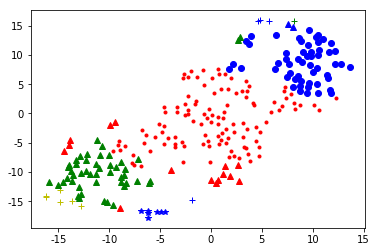

        ma5      ma10    v_ma10  turnover    volume  p_change  类别数目
0  1.083147  1.095791 -0.817674 -0.141440 -0.766816  0.162296    30
1 -0.238806 -0.235842 -0.379013 -0.191112 -0.396233 -0.590170    69
2 -0.487845 -0.495433  2.394950  0.703525  2.809231  0.039241    17
3 -0.071631 -0.075156 -0.422562  1.066170  0.437052  3.630259     6
4  3.741593  3.644348 -0.697698  6.763577  0.240546 -4.732218     1
5  6.462853  6.447870 -0.843593  1.225730 -0.811617 -0.884538     3
6 -0.533146 -0.535433  0.796413 -0.256983  0.589325 -0.043626    54
7  0.880941  0.854585  0.151257  2.894060  0.101462 -0.503776    10
8 -0.174055 -0.172463 -0.479784 -0.440522 -0.511309  0.469727    60


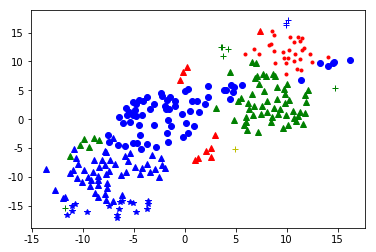

--------正在计算所有买入日期---------
      code        date   open  close
0   600074  2016-04-05  16.78  16.80
1   600111  2016-04-05  12.98  13.12
2   600406  2016-04-05  14.75  15.04
3   600547  2016-04-05  26.47  27.04
4   600549  2016-04-05  20.10  20.35
5   600588  2016-04-05  21.46  22.28
6   600649  2016-04-05  16.15  16.75
7   601111  2016-04-05   7.14   7.40
8   601788  2016-04-05  19.70  19.98
9       60  2016-04-05  11.54  11.65
10     959  2016-04-05   4.81   4.95
11    2081  2016-04-05  17.46  17.55
12    2310  2016-04-05  22.00  22.51
13    2411  2016-04-05  17.24  17.52
14    2456  2016-04-05  26.90  27.70
15  600074  2016-04-11  15.93  16.09
16  600111  2016-04-11  12.61  12.97
17  600406  2016-04-11  14.99  14.81
18  600547  2016-04-11  30.00  30.38
19  600549  2016-04-11  18.78  20.30
20  600588  2016-04-11  21.19  21.27
21  600649  2016-04-11  16.01  15.99
22  601111  2016-04-11   7.22   7.18
23  601788  2016-04-11  19.60  19.10
24      60  2016-04-11  10.86  11.02
--------正在

In [97]:
begin ='2016-04-01'
end = '2016-04-15'
cash = 10000000
(s,d) = jisuan(begin,end)

,code,date,open,close
0,600074,2016-04-05,16.78,16.80
1,600111,2016-04-05,12.98,13.12
2,600406,2016-04-05,14.75,15.04
3,600547,2016-04-05,26.47,27.04
4,600549,2016-04-05,20.10,20.35
5,600588,2016-04-05,21.46,22.28
6,600649,2016-04-05,16.15,16.75
7,601111,2016-04-05,7.14,7.40
8,601788,2016-04-05,19.70,19.98
9,60,2016-04-05,11.54,11.65


请输入策略开始时间：2016-04-01
请输入策略结束时间：2016-05-27
请输入每次选取的收益率排名：6
请输入策略本金：1000000
--------正在计算时间区间---------
            日期 buy end select
0   2016-04-01   F   F      T
1   2016-04-05   T   F      F
2   2016-04-06   0   0      0
3   2016-04-07   0   0      0
4   2016-04-08   F   T      T
5   2016-04-11   T   F      F
6   2016-04-12   0   0      0
7   2016-04-13   0   0      0
8   2016-04-14   0   0      0
9   2016-04-15   F   T      T
10  2016-04-18   T   F      F
11  2016-04-19   0   0      0
12  2016-04-20   0   0      0
13  2016-04-21   0   0      0
14  2016-04-22   F   T      T
15  2016-04-25   T   F      F
16  2016-04-26   0   0      0
17  2016-04-27   0   0      0
18  2016-04-28   0   0      0
19  2016-04-29   F   T      T
20  2016-05-03   T   F      F
21  2016-05-04   0   0      0
22  2016-05-05   0   0      0
23  2016-05-06   F   T      T
24  2016-05-09   T   F      F
25  2016-05-10   0   0      0
26  2016-05-11   0   0      0
27  2016-05-12   0   0      0
28  2016-05-13   F   T      T


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but 

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but 

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but 

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: 
.ix is deprec

,日期,可用资金,持股价值,总资产
0,2016-04-01,1.000000e+06,0.000000e+00,1.000000e+06
1,2016-04-05,0.000000e+00,1.000000e+06,1.000000e+06
2,2016-04-06,0.000000e+00,1.009162e+06,1.009162e+06
3,2016-04-07,0.000000e+00,1.007721e+06,1.007721e+06
4,2016-04-08,9.896844e+05,0.000000e+00,9.896844e+05
5,2016-04-11,0.000000e+00,9.896844e+05,9.896844e+05
6,2016-04-12,0.000000e+00,9.974851e+05,9.974851e+05
7,2016-04-13,0.000000e+00,9.985532e+05,9.985532e+05
8,2016-04-14,0.000000e+00,1.008977e+06,1.008977e+06
9,2016-04-15,1.009131e+06,0.000000e+00,1.009131e+06


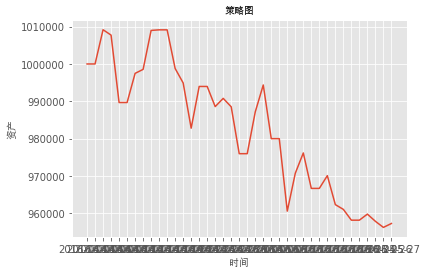

In [44]:
begin =input('请输入策略开始时间：')
end = input('请输入策略结束时间：')
geshu = input('请输入每次选取的收益率排名：')
geshu = int(geshu)
cash = input('请输入策略本金：')
cash = int(cash)
result = jisuan(begin,end)
result

请输入策略开始时间：2016-02-05
请输入策略结束时间：2016-06-27
请输入每次选取的收益率排名：6
请输入策略本金：1000000
--------正在计算时间区间---------
            日期 buy end select
0   2016-02-05   F   F      T
1   2016-02-15   T   F      F
2   2016-02-16   0   0      0
3   2016-02-17   0   0      0
4   2016-02-18   0   0      0
5   2016-02-19   F   T      T
6   2016-02-22   T   F      F
7   2016-02-23   0   0      0
8   2016-02-24   0   0      0
9   2016-02-25   0   0      0
10  2016-02-26   F   T      T
11  2016-02-29   T   F      F
12  2016-03-01   0   0      0
13  2016-03-02   0   0      0
14  2016-03-03   0   0      0
15  2016-03-04   F   T      T
16  2016-03-07   T   F      F
17  2016-03-08   0   0      0
18  2016-03-09   0   0      0
19  2016-03-10   0   0      0
20  2016-03-11   F   T      T
21  2016-03-14   T   F      F
22  2016-03-15   0   0      0
23  2016-03-16   0   0      0
24  2016-03-17   0   0      0
25  2016-03-18   F   T      T
26  2016-03-21   T   F      F
27  2016-03-22   0   0      0
28  2016-03-23   0   0      0


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but 

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but 

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but 

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
            代码         日期   开盘价(元)      市盈率   收盘价(元)
0    600015.SH 2016-02-15   9.0237   5.2627   8.9659
1    600016.SH 2016-02-15   8.0281   6.6940   8.1436
2    600000.SH 2016-02-15  15.8795   6.8010  16.2946
3    600011.SH 2016-02-15   6.2102   7.3653   6.2759
4    600004.SH 2016-02-15  11.7937  11.3248  12.0475
5    600009.SH 2016-02-15  25.1821  20.4309  26.4431
6    600015.SH 2016-02-22   9.2551   5.5570   9.4672
7    600016.SH 2016-02-22   8.2591   6.8048   8.2784
8    600000.SH 2016-02-22  16.2946   6.8010  16.2946
9    600011.SH 2016-02-22   6.5766   7.7953   6.6423
10   600004.SH 2016-02-22  12.4673  11.9121  12.6723
11   600009.SH 2016-02-22  27.6845  21.5499  27.8914
12   600015.SH 2016-02-29   8.9852   5.2684   8.9755
13   600016.SH 2016-02-29   8.0194   6.6861   8.2039
14   600000.SH 2016-02-29  16.2946   6.8010  16.2946
15   6

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but 

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but 

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but 

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: 
.ix is deprec

,日期,可用资金,持股价值,总资产
0,2016-02-05,1.000000e+06,0.000000e+00,1.000000e+06
1,2016-02-15,0.000000e+00,1.000000e+06,1.000000e+06
2,2016-02-16,0.000000e+00,1.022399e+06,1.022399e+06
3,2016-02-17,0.000000e+00,1.037580e+06,1.037580e+06
4,2016-02-18,0.000000e+00,1.051436e+06,1.051436e+06
5,2016-02-19,1.042713e+06,0.000000e+00,1.042713e+06
6,2016-02-22,0.000000e+00,1.042713e+06,1.042713e+06
7,2016-02-23,0.000000e+00,1.059335e+06,1.059335e+06
8,2016-02-24,0.000000e+00,1.053057e+06,1.053057e+06
9,2016-02-25,0.000000e+00,1.064761e+06,1.064761e+06


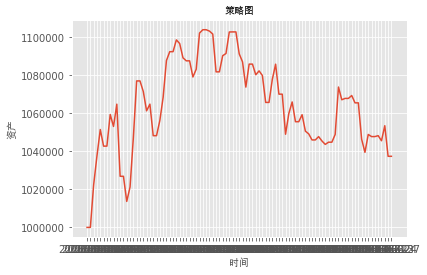

In [46]:
begin =input('请输入策略开始时间：')
end = input('请输入策略结束时间：')
geshu = input('请输入每次选取的收益率排名：')
geshu = int(geshu)
cash = input('请输入策略本金：')
cash = int(cash)
result = jisuan(begin,end)
result